In [25]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from sklearn.metrics import (
    accuracy_score, f1_score, roc_auc_score, 
    precision_recall_curve, auc, confusion_matrix, classification_report
)
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader, TensorDataset

In [26]:
# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Load the data (as per your instructions)
X_train_scaled = np.load('X_train.npy')
y_train = np.load('y_train.npy')
X_test_scaled = np.load('X_test.npy')
y_test = np.load('y_test.npy')

In [27]:
# Convert numpy arrays to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_scaled)
y_train_tensor = torch.FloatTensor(y_train)
X_test_tensor = torch.FloatTensor(X_test_scaled)
y_test_tensor = torch.FloatTensor(y_test)


In [28]:
# Create validation split (20% of training data)
val_size = int(0.2 * len(X_train_tensor))
train_size = len(X_train_tensor) - val_size

train_dataset = TensorDataset(X_train_tensor[:train_size], y_train_tensor[:train_size])
val_dataset = TensorDataset(X_train_tensor[train_size:], y_train_tensor[train_size:])
test_dataset = TensorDataset(X_test_tensor, y_test_tensor)

## Experimenting with Learning Rate

Initially, I used a learning rate of **0.0008** to match my pure Python implementation





However, I observed that the training process was unstable:
- The validation loss often fluctuated and sometimes increased unexpectedly.
- Validation F1 scores showed irregular jumps instead of steady improvement.

To stabilize training, I reduced the learning rate gradually:
- First to **0.00008**: this reduced fluctuations but some instability remained.
- Finally to **0.00003**: training became much smoother and validation metrics improved consistently.

I decided to use **0.00003** as the final learning rate because it offered the best balance between convergence speed and stability in training.

Additionally, I applied L2 regularization to help reduce overfitting.


In [35]:
batch_size = 256
learning_rate = 0.00003
epochs = 200

In [36]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)
test_loader = DataLoader(test_dataset, batch_size=batch_size)

## Neural Network Architecture - same as pure py implementation


In [ ]:
class NoShowPredictor(nn.Module):
    def __init__(self, input_size):
        super(NoShowPredictor, self).__init__()
        self.dense1 = nn.Linear(input_size, 64)
        self.relu1 = nn.ReLU()
        self.dense2 = nn.Linear(64, 32)
        self.relu2 = nn.ReLU()
        self.dense3 = nn.Linear(32, 1)
        self.sigmoid = nn.Sigmoid()
        
        # Initialize weights with He initialization
        nn.init.kaiming_normal_(self.dense1.weight, mode='fan_in', nonlinearity='relu')
        nn.init.kaiming_normal_(self.dense2.weight, mode='fan_in', nonlinearity='relu')
        nn.init.xavier_normal_(self.dense3.weight)
        
        # Initialize biases to zero
        nn.init.zeros_(self.dense1.bias)
        nn.init.zeros_(self.dense2.bias)
        nn.init.zeros_(self.dense3.bias)
    
    def forward(self, x):
        x = self.dense1(x)
        x = self.relu1(x)
        x = self.dense2(x)
        x = self.relu2(x)
        x = self.dense3(x)
        x = self.sigmoid(x)
        return x

neg, pos = np.bincount(y_train)
total = neg + pos
class_weights = torch.tensor([1.0, total / (2.0 * pos)], dtype=torch.float32)

model = NoShowPredictor(X_train_scaled.shape[1])
criterion = nn.BCELoss(weight=class_weights[1] if (y_train == 1).any() else None)
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-4)  # L2 regularization

training loop

In [ ]:
train_losses = []
val_losses = []
val_accuracies = []
val_f1_scores = []
val_pr_aucs = []

for epoch in range(epochs):
    model.train()
    epoch_loss = 0
    
    for batch_X, batch_y in train_loader:
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X).squeeze()
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimize
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item() * batch_X.size(0)
    
    # Calculate average training loss for the epoch
    train_loss = epoch_loss / len(train_loader.dataset)
    train_losses.append(train_loss)
    
    # Validation
    model.eval()
    val_loss = 0
    all_preds = []
    all_probs = []
    all_true = []
    
    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            outputs = model(batch_X).squeeze()
            loss = criterion(outputs, batch_y)
            val_loss += loss.item() * batch_X.size(0)
            
            probs = outputs.numpy()
            preds = (probs > 0.5).astype(int)
            
            all_probs.extend(probs)
            all_preds.extend(preds)
            all_true.extend(batch_y.numpy())
    
    # Calculate validation metrics
    val_loss = val_loss / len(val_loader.dataset)
    val_losses.append(val_loss)
    
    val_acc = accuracy_score(all_true, all_preds)
    val_f1 = f1_score(all_true, all_preds)
    precision, recall, _ = precision_recall_curve(all_true, all_probs)
    val_pr_auc = auc(recall, precision)
    
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)
    val_pr_aucs.append(val_pr_auc)
    
    if epoch % 10 == 0 or epoch == epochs - 1:
        print(f"Epoch {epoch + 1}: Train Loss={train_loss:.4f} | Val Loss={val_loss:.4f} | Val Acc={val_acc:.4f} | F1={val_f1:.4f} | PR AUC={val_pr_auc:.4f}")


Epoch 1: Train Loss=1.1608 | Val Loss=1.1436 | Val Acc=0.6849 | F1=0.1377 | PR AUC=0.2923
Epoch 11: Train Loss=1.0476 | Val Loss=1.0505 | Val Acc=0.7086 | F1=0.0480 | PR AUC=0.3338
Epoch 21: Train Loss=1.0379 | Val Loss=1.0414 | Val Acc=0.7095 | F1=0.0408 | PR AUC=0.3413
Epoch 31: Train Loss=1.0331 | Val Loss=1.0371 | Val Acc=0.7108 | F1=0.0364 | PR AUC=0.3458
Epoch 41: Train Loss=1.0300 | Val Loss=1.0346 | Val Acc=0.7114 | F1=0.0347 | PR AUC=0.3489
Epoch 51: Train Loss=1.0277 | Val Loss=1.0327 | Val Acc=0.7113 | F1=0.0359 | PR AUC=0.3515
Epoch 61: Train Loss=1.0260 | Val Loss=1.0316 | Val Acc=0.7118 | F1=0.0278 | PR AUC=0.3536
Epoch 71: Train Loss=1.0246 | Val Loss=1.0306 | Val Acc=0.7120 | F1=0.0313 | PR AUC=0.3554
Epoch 81: Train Loss=1.0234 | Val Loss=1.0299 | Val Acc=0.7122 | F1=0.0331 | PR AUC=0.3569
Epoch 91: Train Loss=1.0224 | Val Loss=1.0295 | Val Acc=0.7128 | F1=0.0285 | PR AUC=0.3579
Epoch 101: Train Loss=1.0216 | Val Loss=1.0290 | Val Acc=0.7129 | F1=0.0332 | PR AUC=0.3592

In [37]:
model.eval()
test_preds = []
test_probs = []
test_true = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        outputs = model(batch_X).squeeze()
        probs = outputs.numpy()
        preds = (probs > 0.5).astype(int)
        
        test_probs.extend(probs)
        test_preds.extend(preds)
        test_true.extend(batch_y.numpy())

# metrics:-
print("\nFinal Evaluation on Test Set")
print(f"Accuracy: {accuracy_score(test_true, test_preds):.4f}")
print(f"F1 Score: {f1_score(test_true, test_preds):.4f}")
print(f"ROC AUC: {roc_auc_score(test_true, test_probs):.4f}")

precision, recall, _ = precision_recall_curve(test_true, test_probs)
print(f"PR AUC: {auc(recall, precision):.4f}")

# Confusion Matrix and Classification Report
print("\nConfusion Matrix:")
print(confusion_matrix(test_true, test_preds))

print("\nClassification Report:")
print(classification_report(test_true, test_preds))



Final Evaluation on Test Set
Accuracy: 0.7142
F1 Score: 0.0292
ROC AUC: 0.5992
PR AUC: 0.3655

Confusion Matrix:
[[9915   64]
 [3927   60]]

Classification Report:
              precision    recall  f1-score   support

         0.0       0.72      0.99      0.83      9979
         1.0       0.48      0.02      0.03      3987

    accuracy                           0.71     13966
   macro avg       0.60      0.50      0.43     13966
weighted avg       0.65      0.71      0.60     13966



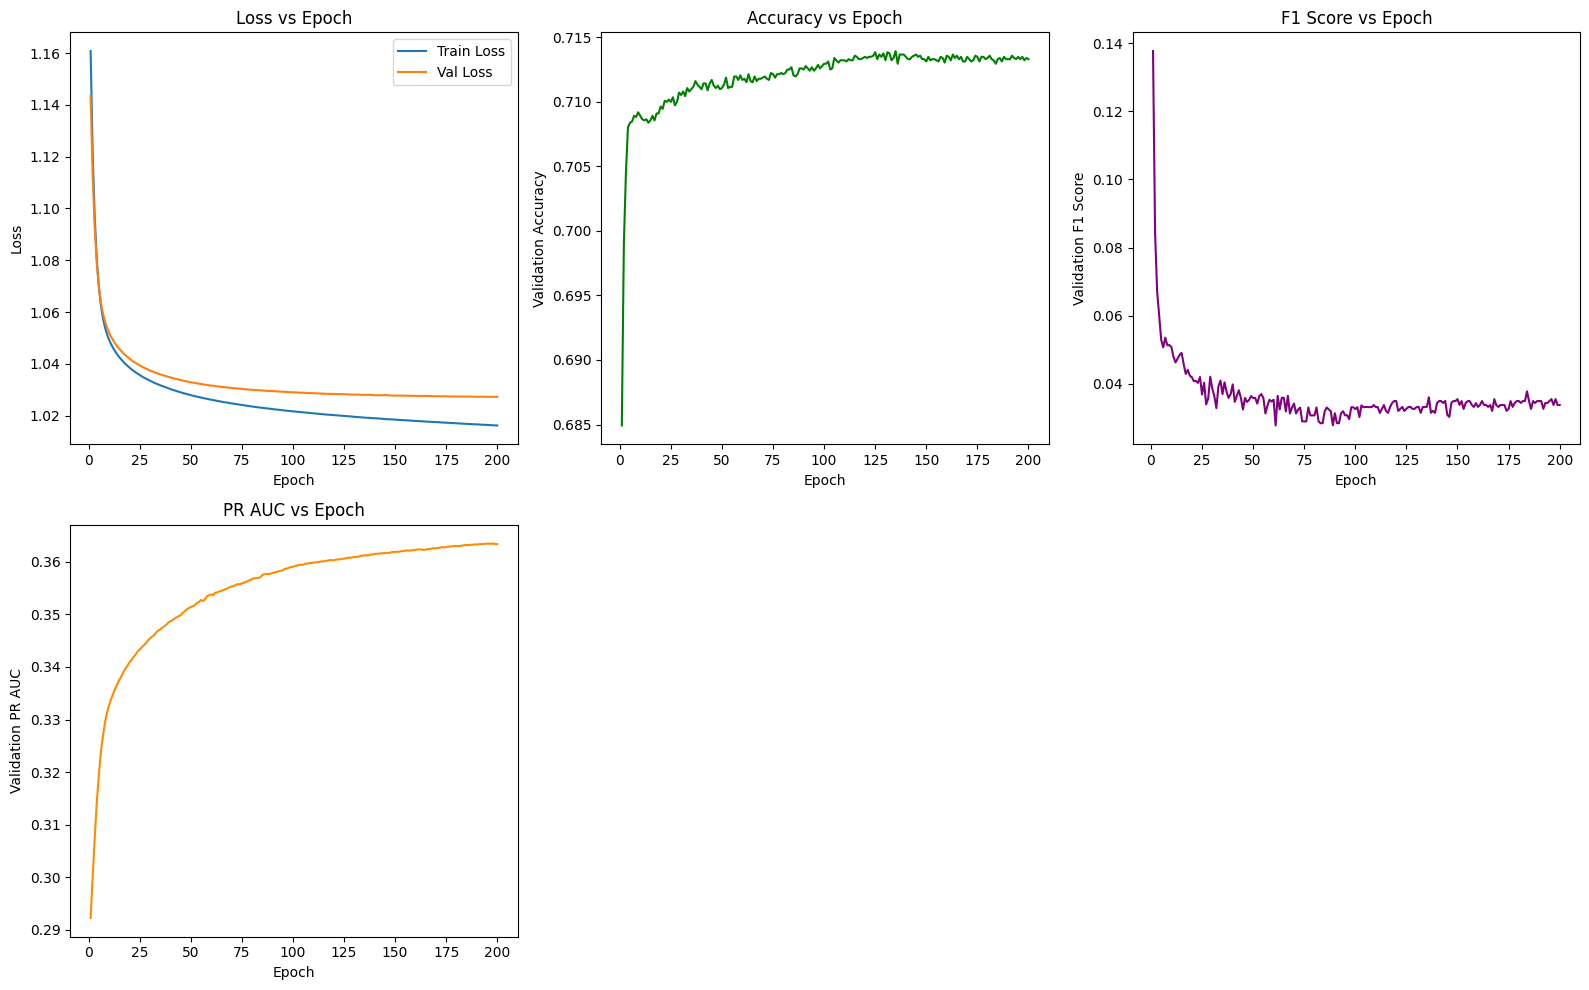

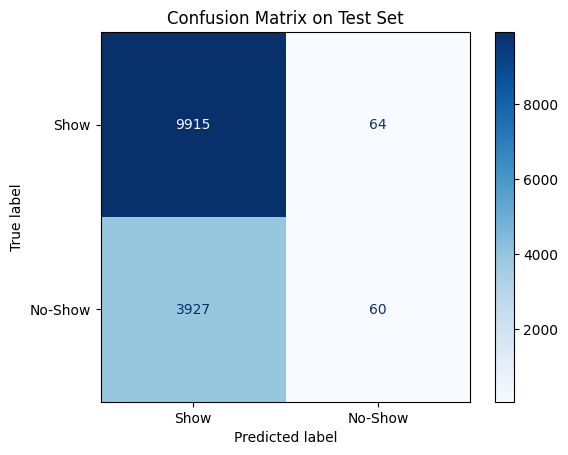

In [34]:
# plot the metrics
epochs_range = range(1, epochs + 1)

plt.figure(figsize=(16, 10))

plt.subplot(2, 3, 1)
plt.plot(epochs_range, train_losses, label='Train Loss')
plt.plot(epochs_range, val_losses, label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs Epoch')
plt.legend()

plt.subplot(2, 3, 2)
plt.plot(epochs_range, val_accuracies, color='green')
plt.xlabel('Epoch')
plt.ylabel('Validation Accuracy')
plt.title('Accuracy vs Epoch')

plt.subplot(2, 3, 3)
plt.plot(epochs_range, val_f1_scores, color='purple')
plt.xlabel('Epoch')
plt.ylabel('Validation F1 Score')
plt.title('F1 Score vs Epoch')


plt.subplot(2, 3, 4)
plt.plot(epochs_range, val_pr_aucs, color='darkorange')
plt.xlabel('Epoch')
plt.ylabel('Validation PR AUC')
plt.title('PR AUC vs Epoch')

plt.tight_layout()
plt.show()

# for confusion matrix
cm = confusion_matrix(test_true, test_preds)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Show", "No-Show"])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix on Test Set")
plt.show()